## Project NLP | Business Case: Automated Customer Reviews

In [7]:
import pandas as pd
from transformers import BertTokenizer
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
import re
from nltk.stem import PorterStemmer

In [8]:
# Download NLTK resources
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [9]:
# Load the Amazon product reviews dataset
data = pd.read_csv('/content/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5000 non-null   object 
 1   dateAdded            5000 non-null   object 
 2   dateUpdated          5000 non-null   object 
 3   name                 5000 non-null   object 
 4   asins                5000 non-null   object 
 5   brand                5000 non-null   object 
 6   categories           5000 non-null   object 
 7   primaryCategories    5000 non-null   object 
 8   imageURLs            5000 non-null   object 
 9   keys                 5000 non-null   object 
 10  manufacturer         5000 non-null   object 
 11  manufacturerNumber   5000 non-null   object 
 12  reviews.date         5000 non-null   object 
 13  reviews.dateAdded    1052 non-null   object 
 14  reviews.dateSeen     5000 non-null   object 
 15  reviews.doRecommend  5000 non-null   b

In [11]:
data.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.dateSeen,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-09-18T00:00:00Z,2017...",False,NaN,0,3,http://reviews.bestbuy.com/3545/5442403/review...,I thought it would be as big as small paper bu...,Too small,llyyue,https://www.newegg.com/Product/Product.aspx%25...
1,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",True,NaN,0,5,http://reviews.bestbuy.com/3545/5442403/review...,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,Charmi,https://www.newegg.com/Product/Product.aspx%25...
2,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,4,https://reviews.bestbuy.com/3545/5442403/revie...,Didnt know how much i'd use a kindle so went f...,Great for the price,johnnyjojojo,https://www.newegg.com/Product/Product.aspx%25...
3,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-10-09T00:00:00Z,True,177283626.0,3,5,https://redsky.target.com/groot-domain-api/v1/...,I am 100 happy with my purchase. I caught it o...,A Great Buy,Kdperry,https://www.newegg.com/Product/Product.aspx%25...
4,AVqVGZNvQMlgsOJE6eUY,2017-03-03T16:56:05Z,2018-10-25T16:36:31Z,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Amazon,"Computers,Electronics Features,Tablets,Electro...",Electronics,https://pisces.bbystatic.com/image2/BestBuy_US...,allnewkindleereaderblack6glarefreetouchscreend...,...,2018-05-27T00:00:00Z,True,NaN,0,5,https://reviews.bestbuy.com/3545/5442403/revie...,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,Johnnyblack,https://www.newegg.com/Product/Product.aspx%25...


In [12]:
data.isnull().sum()

,0
id,0
dateAdded,0
dateUpdated,0
name,0
asins,0
brand,0
categories,0
primaryCategories,0
imageURLs,0
keys,0


## Prepriseccing

In [13]:
import pandas as pd



# Drop rows with missing essential information
data.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)

# Text Cleaning
# Lowercase text
data['clean_text'] = data['reviews.text'].str.lower()

# Remove special characters and symbols
data['clean_text'] = data['clean_text'].str.replace('[^a-zA-Z\s]', '')



# Mapping Star Ratings to Sentiment Classes
def map_star_rating_to_sentiment(star_rating):
    if star_rating in [1, 2]:
        return 'Negative'
    elif star_rating == 3:
        return 'Neutral'
    elif star_rating in [4, 5]:
        return 'Positive'

data['sentiment'] = data['reviews.rating'].apply(map_star_rating_to_sentiment)

# Calculate the total count of each sentiment class
sentiment_counts = data['sentiment'].value_counts()

# Display the total count of each sentiment class
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment}: {count}")



Positive: 4686
Neutral: 197
Negative: 117


# Visualize Star Ratings Distribution

<ipython-input-14-cc06fe422eaf>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='reviews.rating', palette='Blues')


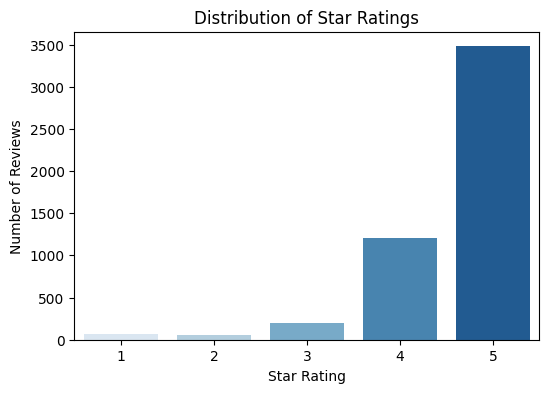

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='reviews.rating', palette='Blues')
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.show()


In [15]:
# Undersample Positive Class
# First, check class distribution
print(data['sentiment'].value_counts())

# Separate the classes
positive_df = data[data['sentiment'] == 'Positive']
neutral_df = data[data['sentiment'] == 'Neutral']
negative_df = data[data['sentiment'] == 'Negative']

# Set undersample size to match the minority class
target_size = min(len(neutral_df), len(negative_df))  # smallest class size

# Undersample Positive class
positive_df_sampled = positive_df.sample(n=target_size, random_state=42)

# Combine all classes
balanced_df = pd.concat([positive_df_sampled, neutral_df, negative_df], axis=0)

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Show new class distribution
print("\nBalanced Class Distribution:")
print(balanced_df['sentiment'].value_counts())


sentiment
Positive    4686
Neutral      197
Negative     117
Name: count, dtype: int64

Balanced Class Distribution:
sentiment
Neutral     197
Negative    117
Positive    117
Name: count, dtype: int64


<ipython-input-16-e5dedf28c94c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='sentiment', palette='Set2')


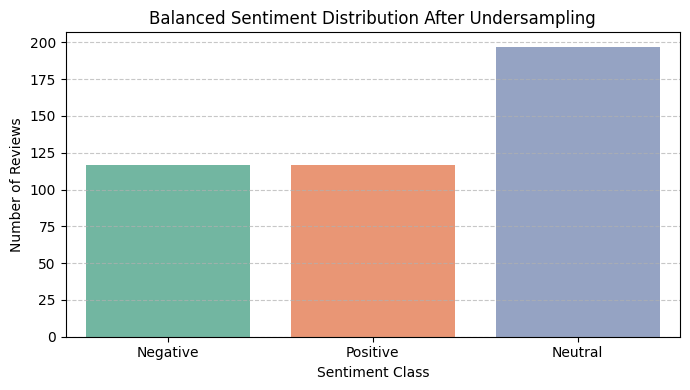

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.countplot(data=balanced_df, x='sentiment', palette='Set2')
plt.title('Balanced Sentiment Distribution After Undersampling')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Reviews')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [17]:
# Data Splitting
from sklearn.model_selection import train_test_split

X = data['clean_text']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Task 1. Classification with pre-trained models.

## bert-base-uncased

In [18]:
 # bert-base-uncased
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch



# Encode the labels if they are strings
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_mapping = {index: label for label, index in enumerate(label_encoder.classes_)}
print("Label Mapping:", label_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 classes

# Tokenize the training and testing data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors='pt')

# Create PyTorch Dataset
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor([self.labels[idx]])  # Ensure labels are also tensors
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, y_train)
test_dataset = ReviewDataset(test_encodings, y_test)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./bert_logs',
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


Label Mapping: {'Negative': 0, 'Neutral': 1, 'Positive': 2}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abrar-alanazi (abrar-alanazi-ironhack) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.248800
1000,0.147800
1500,0.093400


TrainOutput(global_step=1500, training_loss=0.1633363978068034, metrics={'train_runtime': 1106.9878, 'train_samples_per_second': 10.84, 'train_steps_per_second': 1.355, 'total_flos': 3157361012736000.0, 'train_loss': 0.1633363978068034, 'epoch': 3.0})

Accuracy: 0.9410
Precision: [0.64285714 0.39130435 0.97234043]
Recall: [0.375      0.46153846 0.97545358]
F1 Score: [0.47368421 0.42352941 0.97389451]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.64      0.38      0.47        24
     Neutral       0.39      0.46      0.42        39
    Positive       0.97      0.98      0.97       937

    accuracy                           0.94      1000
   macro avg       0.67      0.60      0.62      1000
weighted avg       0.94      0.94      0.94      1000



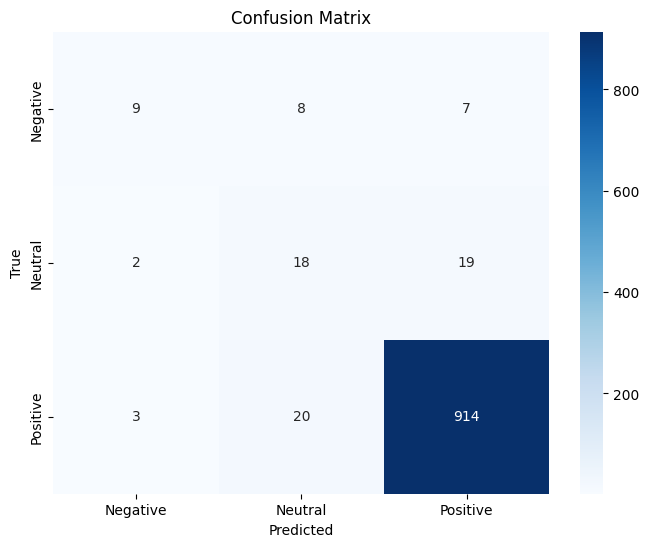

Accuracy: 0.9410
Precision: [0.64285714 0.39130435 0.97234043]
Recall: [0.375      0.46153846 0.97545358]
F1 Score: [0.47368421 0.42352941 0.97389451]


In [19]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the test dataset
predictions = trainer.predict(test_dataset)
predicted_class = predictions.predictions.argmax(axis=-1)
true_class = y_test  # Use y_test as the true labels

# Calculate evaluation metrics
accuracy = accuracy_score(true_class, predicted_class)
precision, recall, f1, _ = precision_recall_fscore_support(true_class, predicted_class, average=None)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_class, predicted_class)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print classification report
print("Classification Report:")
print(classification_report(true_class, predicted_class, target_names=label_encoder.classes_))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

In [20]:
# Save the best model
model.save_pretrained('./best_bert_model')
tokenizer.save_pretrained('./best_bert_model')  # Also save the tokenizer

('./best_bert_model/tokenizer_config.json',
 './best_bert_model/special_tokens_map.json',
 './best_bert_model/vocab.txt',
 './best_bert_model/added_tokens.json')

# Task 2. Product Category Clustering

In [29]:
# Extract unique product names and categories
unique_products = data[['name', 'primaryCategories']].drop_duplicates().reset_index(drop=True)
print(f"Total unique products: {len(unique_products)}")
unique_products.head()


Total unique products: 23


,name,primaryCategories
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",Electronics
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,"Electronics,Hardware"
2,Amazon Fire TV with 4K Ultra HD and Alexa Voic...,Electronics
3,Amazon - Echo Plus w/ Built-In Hub - Silver,"Electronics,Hardware"
4,Amazon 9W PowerFast Official OEM USB Charger a...,Electronics


In [30]:
# Generate Sentence-BERT Embeddings
# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # You can use 'paraphrase-MiniLM-L6-v2' as well

# Encode product names
embeddings = model.encode(unique_products['name'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# Apply KMeans Clustering
# Set number of meta-categories
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Assign cluster labels to the product list
unique_products['cluster'] = cluster_labels


In [32]:
# Explore & Label Clusters
# Display sample names per cluster
for i in range(k):
    cluster_items = unique_products[unique_products['cluster'] == i]
    print(f"\n🔷 Cluster {i} - Total: {len(cluster_items)}")
    print(cluster_items[['name', 'primaryCategories']].head(10).to_string(index=False))



🔷 Cluster 0 - Total: 3
                                                                   name primaryCategories
 Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case       Electronics
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case       Electronics
Brand New Amazon Kindle Fire 16gb 7" Ips Display Tablet Wifi 16 Gb Blue       Electronics

🔷 Cluster 1 - Total: 9
                                                                                       name           primaryCategories
                      Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                 Electronics
       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue                 Electronics
       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue                 Electronics
Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum Office Supplies,Elec

In [33]:
# Cluster Summary Using Keywords
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_keywords(cluster_data, n=10):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(cluster_data['name'])
    scores = tfidf_matrix.sum(axis=0).A1
    terms = tfidf.get_feature_names_out()
    keywords = [terms[i] for i in scores.argsort()[-n:][::-1]]
    return keywords

for i in range(k):
    cluster_df = unique_products[unique_products['cluster'] == i]
    keywords = get_top_keywords(cluster_df)
    print(f"\n📌 Cluster {i} Keywords: {', '.join(keywords)}")



📌 Cluster 0 Keywords: tablet, 16, display, gb, edition, proof, wi, kid, fi, case

📌 Cluster 1 Keywords: hd, special, offers, tablet, gb, display, fi, wi, includes, 16

📌 Cluster 2 Keywords: amazon, alexa, speaker, bluetooth, enabled, echo, screen, tap, portable, built

📌 Cluster 3 Keywords: kindle, amazon, black, voyage, 4gb, wi, fi, reader, display, special


In [34]:
from sklearn.decomposition import PCA

# Reduce embeddings to 2D for visualization
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

# Add reduced dimensions to DataFrame
unique_products['pca_x'] = reduced_embeddings[:, 0]
unique_products['pca_y'] = reduced_embeddings[:, 1]


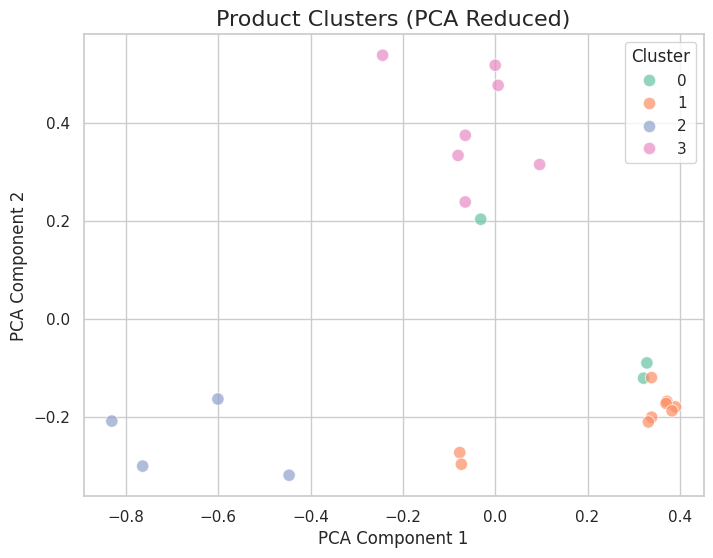

In [36]:
# Plot Clusters
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid", palette="muted")

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=unique_products,
    x='pca_x',
    y='pca_y',
    hue='cluster',
    palette='Set2',
    alpha=0.7,
    s=80
)

# Plot styling
plt.title('Product Clusters (PCA Reduced)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='best')
plt.show()


# Task 3. Summarize reviews using generative AI

In [25]:
# Load T5 model and tokenizer
model_name = 't5-small'  # you can try t5-base or t5-large for better quality
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

def generate_summary(text, max_length=200):
    # Preprocess input text
    input_text = "summarize: " + text.strip().replace("\n", " ")
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=512)

    # Generate summary
    summary_ids = model.generate(input_ids, max_length=max_length, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return output


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [26]:
# Generate Summary per Category
def create_article_for_category(df, category_name):
    category_df = df[df['primaryCategories'] == category_name]

    if category_df.empty:
        return f"No data found for category {category_name}."

    # Top 3 products by average rating
    top_products = category_df.groupby('name')['reviews.rating'].mean().sort_values(ascending=False).head(3).index.tolist()
    worst_product = category_df.groupby('name')['reviews.rating'].mean().sort_values(ascending=True).head(1).index[0]

    article_parts = []

    article_parts.append(f"## Best Products in {category_name}\n")
    for product in top_products:
        product_reviews = category_df[category_df['name'] == product]['reviews.text'].tolist()
        selected_reviews = " ".join(product_reviews[:10])
        summary = generate_summary(selected_reviews)
        article_parts.append(f"### {product}\n**Summary:** {summary}\n")

    article_parts.append(f"\n## Worst Product in {category_name}\n")
    worst_reviews = category_df[category_df['name'] == worst_product]['reviews.text'].tolist()
    worst_text = " ".join(worst_reviews[:10])
    worst_summary = generate_summary(worst_text)
    article_parts.append(f"### {worst_product}\n**Why to Avoid:** {worst_summary}\n")

    return "\n".join(article_parts)


In [27]:
# Create Article for Each Category
def create_article_for_category(df, category_name):
    category_df = df[df['primaryCategories'] == category_name]

    if category_df.empty:
        return f"No data found for category {category_name}."

    # Top 3 products by average rating
    top_products = category_df.groupby('name')['reviews.rating'].mean().sort_values(ascending=False).head(3).index.tolist()
    worst_product = category_df.groupby('name')['reviews.rating'].mean().sort_values(ascending=True).head(1).index[0]

    article_parts = []

    article_parts.append(f"## Best Products in {category_name}\n")
    for product in top_products:
        product_reviews = category_df[category_df['name'] == product]['reviews.text'].tolist()
        selected_reviews = " ".join(product_reviews[:10])
        summary = generate_summary(selected_reviews)
        article_parts.append(f"### {product}\n**Summary:** {summary}\n")

    article_parts.append(f"\n## Worst Product in {category_name}\n")
    worst_reviews = category_df[category_df['name'] == worst_product]['reviews.text'].tolist()
    worst_text = " ".join(worst_reviews[:10])
    worst_summary = generate_summary(worst_text)
    article_parts.append(f"### {worst_product}\n**Why to Avoid:** {worst_summary}\n")

    return "\n".join(article_parts)


In [28]:
# Example: Generate for the "Electronics" category
category_name = "Electronics"
article = create_article_for_category(data, category_name)

# Display the blog-style article
print(article)


## Best Products in Electronics

### Amazon Fire TV with 4K Ultra HD and Alexa Voice Remote (Pendant Design) | Streaming Media Player
**Summary:** a lazy mans drean when it is combined with Alexa. I really enjoy my Fire stick. it works great. one in each of the main rooms. I love it! I love it! I love it!

### Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders
**Summary:** i bought this because the package said it was a fast charger only to find it charges at normal speed... That was disappointing. I'm pretty sure I'm not doing anything wrong. it seems pretty self explanatory... not sure how long it will last.

### Kindle Oasis E-reader with Leather Charging Cover - Black, 6" High-Resolution Display (300 ppi), Wi-Fi - Includes Special Offers
**Summary:** amazon still seems to be back-ordered. this is the best kindle ereader yet. the size and weight make it perfect for comfortable reading. if you don't mind the price tag, go for it.


## 